In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

In [2]:
pip install opencv-python


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [6]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
train = get_training_data('/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/chest_xray/train')
test = get_training_data('/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/chest_xray/test')
val = get_training_data('/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/chest_xray/val')

/var/folders/0m/h9z_23v10pj2hclcsszt6v2c0000gn/T/ipykernel_78584/771166761.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

Text(0.5, 1.0, 'NORMAL')

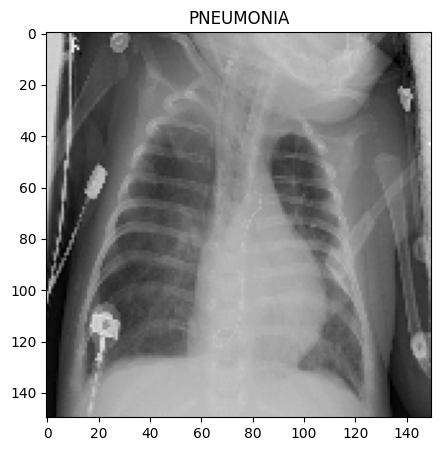

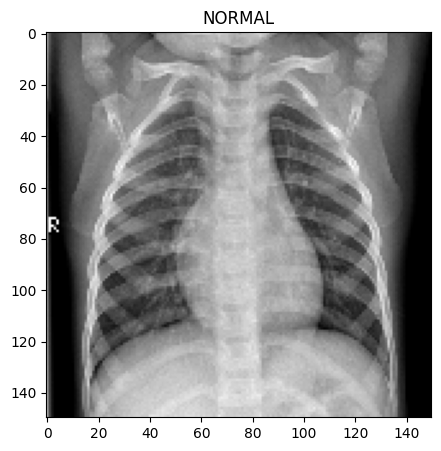

In [9]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])



In [10]:
#x_train.dtype

In [11]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [12]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 40,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(x_train)

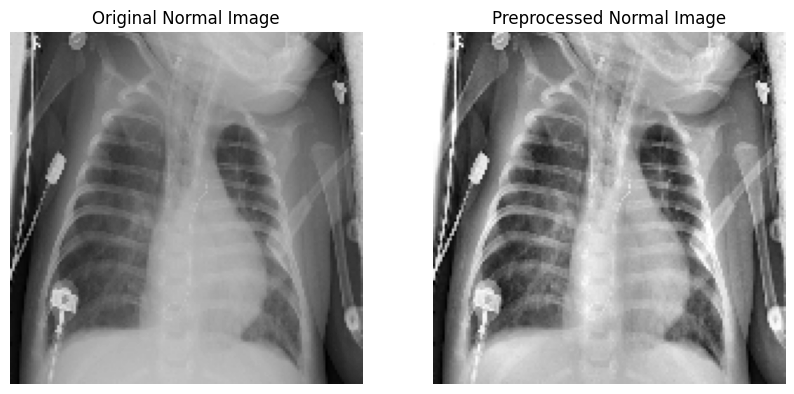

In [14]:
from skimage import exposure
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for preprocessing an individual image
def preprocess_image(img):
    # Resize image
    resized_img = cv2.resize(img, (img_size, img_size))
    
    # Contrast enhancement using histogram equalization
    equalized_img = exposure.equalize_adapthist(resized_img)
    
    # Normalize the image
    normalized_img = equalized_img / 255.0
    
    return normalized_img

# Apply preprocessing to all images in the dataset
x_train_preprocessed = np.array([preprocess_image(img) for img in x_train])
x_val_preprocessed = np.array([preprocess_image(img) for img in x_val])
x_test_preprocessed = np.array([preprocess_image(img) for img in x_test])

# Add a channel dimension to your input data
x_train_preprocessed = np.expand_dims(x_train_preprocessed, axis=-1)
x_val_preprocessed = np.expand_dims(x_val_preprocessed, axis=-1)

# Ensure consistent batch size for testing
x_test_preprocessed = np.expand_dims(x_test_preprocessed, axis=-1)

# Display original and preprocessed normal chest images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape(img_size, img_size), cmap='gray')
plt.title('Original Normal Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_train_preprocessed[0].reshape(img_size, img_size), cmap='gray')
plt.title('Preprocessed Normal Image')
plt.axis('off')

plt.show()


In [15]:
x_test_preprocessed.shape[0]

624

In [16]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=5,factor=0.5, min_lr=0.1)

In [23]:
history = model.fit(datagen.flow(x_train_preprocessed, y_train, batch_size=32),
                    epochs=12,
                    validation_data=datagen.flow(x_val_preprocessed, y_val),
                    callbacks=[learning_rate_reduction])

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - accuracy: 0.8497 - loss: 0.3525 - val_accuracy: 0.5000 - val_loss: 15.3734 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.8462 - loss: 0.3564 - val_accuracy: 0.5000 - val_loss: 92.7754 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 446ms/step - accuracy: 0.8638 - loss: 0.3300 - val_accuracy: 0.5000 - val_loss: 21.7074 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 446ms/step - accuracy: 0.8699 - loss: 0.3232 - val_accuracy: 0.5000 - val_loss: 198.2084 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 428ms/step - accuracy: 0.8557 - loss: 0.3476 - val_accuracy: 0.5000 - val_loss: 78.6973 - learning_rate: 0.0010
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 424ms/step - accuracy: 0.8660 - loss: 0.3122 - val_accuracy: 0.5000 - val_loss: 20.0044 - learning_rate: 0.0010
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 428ms/step - accura

In [28]:
print("Loss of the model is - ", model.evaluate(x_test_preprocessed, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test_preprocessed, y_test)[1] * 100, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8889 - loss: 15.0238
Loss of the model is -  52.1817626953125
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8889 - loss: 15.0238
Accuracy of the model is -  62.5 %


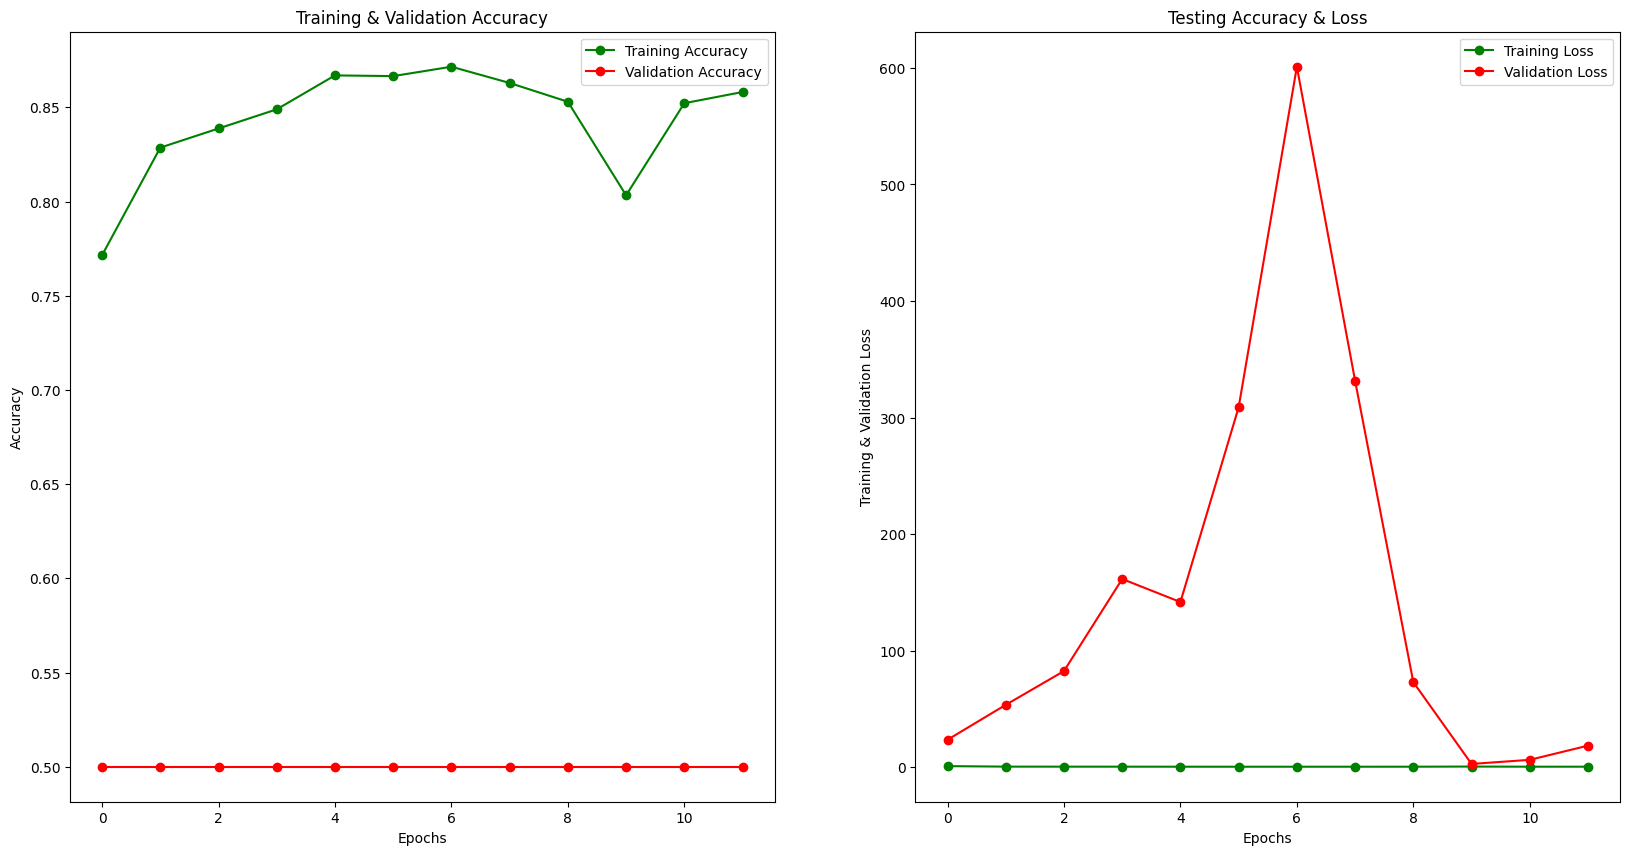

In [20]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [21]:
predictions = model.predict_classes(x_test_preprocessed)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm